In [36]:
import networkx as nx
import random
import copy
import time
import matplotlib.pyplot as plt
import sys
from collections import defaultdict
%matplotlib inline
initial_start = time.time()

NUM_NODES = 1000
MAX_RADIUS_TO_CHECK = 6

''' For avg degree = 6'''
G = nx.barabasi_albert_graph(NUM_NODES, 3)
# G = nx.watts_strogatz_graph(NUM_NODES, 6, 1)
# G = nx.powerlaw_cluster_graph(NUM_NODES, 3, 1)

In [27]:
''' Graph Characterization Metrics '''
print("Average degree = ", 2 * G.number_of_edges() / G.number_of_nodes())
print("Clustering Coefficient = ", nx.average_clustering(G))
print("Average Path Length = ", nx.average_shortest_path_length(G))

Average degree =  5.982
Clustering Coefficient =  0.03622026139608953
Average Path Length =  3.4375615615615613


In [28]:
start = time.time()

def change_ds(spl_gen, num_nodes, max_radius):
    ''' 
    Transforms 'spl_gen' into the accepted datastructure
    by the 'infected_average_by_separation_degree' method
    '''
    result = []
    for n in range(num_nodes):
        di_tmp = {}
        for entry in spl_gen:  
            for radius in range(1, max_radius + 1):
                li_tmp = []
                for node, dist in entry[1].items():
                    if dist == radius:
                        li_tmp.append(node)
                if li_tmp != []:
                    di_tmp[radius - 1] = li_tmp
            result.append(copy.copy(di_tmp))
            
    return result

spl = nx.all_pairs_shortest_path_length(G)
separation_degrees = change_ds(spl, NUM_NODES, MAX_RADIUS_TO_CHECK)

print('Time:', time.time() - start, "seconds")

Time: 4.416478395462036 seconds


In [29]:
def infected_percentage(nodes, infected) :
    count = 0
    for node in nodes :
        if node in infected :
            count += 1
    
    return count / len(nodes)

def infected_average_by_separation_degree(G, separation_degrees, infected) :
    node_count = {}
    percentage_sum = {}
    
    for node in range(0, len(separation_degrees)) :
        if node in infected :
            for degree in separation_degrees[node] :
                if degree not in percentage_sum.keys() :
                    percentage_sum[degree] = 0
                    node_count[degree] = 0
                percentage_sum[degree] += infected_percentage(separation_degrees[node][degree], infected)
                node_count[degree] += 1
        
    average_by_separation_degree = {}
    
    for separation_degree in percentage_sum :
        average_by_separation_degree[separation_degree] = percentage_sum[separation_degree] / node_count[separation_degree]
            
    return average_by_separation_degree

In [30]:
import ndlib.models.ModelConfig as mc
import ndlib.models.epidemics.SIModel as si
import ndlib.models.opinions.VoterModel as vt

# Model selection
model = si.SIModel(G)

# Model Configuration
cfg = mc.Configuration()
cfg.add_model_parameter('beta', 0.05) # probability of infection
cfg.add_model_parameter("percentage_infected", 0) # initially infected % (if 0 => 1 infected)
model.set_initial_status(cfg)

C:\ProgramData\Anaconda3\lib\site-packages\ndlib\models\DiffusionModel.py:161: UserWarning: Graph with less than 100 nodes: a single node will be set as infected
  warnings.warn('Graph with less than 100 nodes: a single node will be set as infected')


In [31]:
start = time.time()

infected = []
it_count = 0
while len(infected) < NUM_NODES / 2 :
    it_count += 1
    iteration = model.iteration()
    for node, i in iteration['status'].items() :
        if i == 1:
            infected.append(node)

    
avg_traits = infected_average_by_separation_degree(G, separation_degrees, infected)
infected_count = len(infected)

print('Infected count', infected_count)
print('Iterations', it_count)
print(avg_traits)

print('Time:', time.time() - start, "seconds")

Infected count 543
Iterations 30
{0: 0.761568710489805, 1: 0.6792806276409848, 2: 0.5989097819434038, 3: 0.4410775580945805, 4: 0.2450589644784777, 5: 0.08757620695336957}
Time: 2.8013927936553955 seconds


In [32]:
start = time.time()

''' Random distribution of infected nodes '''
def simulate_random_infecteds(G_rand, num_nodes, radius_split_rand, num_infects):
    '''
    Randomly picks the same number of infecteds as in the 
    non-random model (for each iteration of the spreading)
    Returns a list of @infected_average_by_radius lists
    '''
    random_infected = []
    random_not_infected = list(range(0, num_nodes))
    
    for _ in range(num_infects):
        new_inf = random.choice(random_not_infected)
        random_infected.append(new_inf)
        random_not_infected.remove(new_inf)

    avg_trait_sharing_by_radius = infected_average_by_separation_degree(G_rand, separation_degrees, random_infected)
    print(avg_trait_sharing_by_radius)    

    return (avg_trait_sharing_by_radius, random_infected)

avg_random_trait_sharing_by_radius, final_random_infected = simulate_random_infecteds(G, NUM_NODES, separation_degrees, infected_count)

print('Time:', time.time() - start, "seconds")

{0: 0.5847006845579592, 1: 0.566716918745625, 2: 0.5571298819222036, 3: 0.5237443371643499, 4: 0.5657630092623193, 5: 0.7659084467120183}
Time: 3.1601884365081787 seconds


In [33]:
''' Check maximum degree of separation actually found. '''
max_sep_deg = -1
for node in separation_degrees:
    if max_sep_deg < len(node):
        max_sep_deg = len(node)
print("Max separation degree: ", max_sep_deg)

def propensity_by_radius(radius, avg_traits, rand_avg_traits):
    return (avg_traits[radius-1] / rand_avg_traits[radius-1]) - 1

def all_propensities(max_radius, avg_traits, rand_avg_traits):
    all_propensities = []
    for r in range(1, max_radius + 1):
        all_propensities.append(propensity_by_radius(r, avg_traits, rand_avg_traits))
    return all_propensities

def normalized_propensities(max_radius, all_propensities):
    normalized_propensities = []
    for r in range(max_radius):
        normalized_propensities.append(all_propensities[r] / all_propensities[0])
    
    return normalized_propensities

all_props = all_propensities(max_sep_deg, avg_traits, avg_random_trait_sharing_by_radius) 
print(normalized_propensities(max_sep_deg, all_props))

Max separation degree:  6
[1.0, 0.6566236030181117, 0.2479106690664168, -0.5217902383172053, -1.8739334440129314, -2.927857079994722]


In [34]:
''' Count total nodes per degree of separation. '''
total_nodes_per_sep_deg = [0 for _ in range(max_sep_deg)]
for node in separation_degrees :
    for dist in node:
        total_nodes_per_sep_deg[dist] += len(node[dist])

''' Calculate average nodes per degree of separation.
    Note that values can be < 0 because not every node
    has the same number of maximum separation degrees. '''
avg_nodes_per_sep_deg = []
for total_nodes in total_nodes_per_sep_deg:
    avg_nodes_per_sep_deg.append(total_nodes/len(separation_degrees))

print("Avg nodes per degree of separation:", avg_nodes_per_sep_deg)

print("Total time:", time.time() - initial_start)

Avg nodes per degree of separation: [5.982, 79.22, 429.348, 440.686, 45.061, 1.205]
Total time: 22.596693754196167


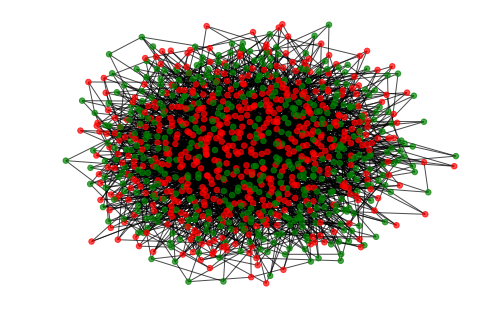

In [38]:
def kawai_draw(G, infected=[]) :
    ''' Draw the graph 'G' following the kamada-kawai algorithm
        and coloring the nodes on the 'infected' variable as red
        and the others as green
    '''
    colors = []
    for node in G :
        if node in infected :
            colors.append('red')
        else :
            colors.append('green')
    nx.draw(G, layout=nx.kamada_kawai_layout(G), node_color=colors, node_size = 30, alpha = 0.7)
    plt.show()
    
kawai_draw(G, infected)

In [11]:
# Saving graph to file

import pickle

with open('2000_nodes_scale_free.graph', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump(G, f)


"\nimport pickle\n\nwith open('2000_nodes_scale_free.graph', 'wb') as f:  # Python 3: open(..., 'wb')\n    pickle.dump(G, f)\n"

In [12]:
# Loading graph from file

import pickle

with open('2000_nodes_scale_free.graph', 'rb') as f:  # Python 3: open(..., 'rb')
    Gtest = pickle.load(f)

print(2 * Gtest.number_of_edges() / Gtest.number_of_nodes())



"\nimport pickle\n\nwith open('2000_nodes_scale_free.graph', 'rb') as f:  # Python 3: open(..., 'rb')\n    Gtest = pickle.load(f)\n\nprint(2 * Gtest.number_of_edges() / Gtest.number_of_nodes())\n"